In [82]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Validate NWB file by creating plots directly from the file

This script reads a SLAP2 NWB file and creates validation plots similar to those
created by the original load_slap2.py script, but directly from the NWB file
using pynwb instead of the original SLAP2 code.

Author: GitHub Copilot (based on original SLAP2 code by Jerome Lecoq)
"""

import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
import argparse
from matplotlib.colors import LinearSegmentedColormap

# Import PyNWB modules
from pynwb import NWBHDF5IO
from pynwb.ophys import TwoPhotonSeries, OpticalChannel, ImageSegmentation, Fluorescence, DfOverF, RoiResponseSeries

def load_nwb_file(nwb_path):
    """
    Load an NWB file
    
    Parameters
    ----------
    nwb_path : str
        Path to the NWB file
        
    Returns
    -------
    nwbfile : NWBFile
        The loaded NWB file
    io : NWBHDF5IO
        The I/O object for the NWB file (needed to close the file properly)
    """
    io = NWBHDF5IO(nwb_path, 'r')
    nwbfile = io.read()
    return nwbfile, io


def validate_nwb(nwb_path, output_dir=None):
    """
    Validate an NWB file by creating plots
    
    Parameters
    ----------
    nwb_path : str
        Path to the NWB file
    output_dir : str, optional
        Path to the output directory for plots
        
    Returns
    -------
    output_dir : str
        Path to the output directory where plots were saved
    """
    # Set default output directory if not provided
    if output_dir is None:
        output_dir = os.path.join(os.path.dirname(nwb_path), 'validation')
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load NWB file
    nwbfile, io = load_nwb_file(nwb_path)
    
    try:
        # 1. Plot metadata and basic information
        plot_metadata(nwbfile, output_dir)
        
        # 2. Plot stimulus information
        plot_stimulus_info(nwbfile, output_dir)
        
        # 3. Plot summary images
        plot_summary_images(nwbfile, output_dir)
        
        # 4. Plot traces with stimulus overlays
        plot_traces_with_stimuli(nwbfile, output_dir)
        
        # 5. Plot segmentation masks
        plot_segmentation_masks(nwbfile, output_dir)
        
        print(f"Validation plots saved to {output_dir}")
    finally:
        # Close the NWB file
        io.close()
    
    return output_dir


def plot_metadata(nwbfile, output_dir):
    """
    Plot metadata from the NWB file
    
    Parameters
    ----------
    nwbfile : NWBFile
        The NWB file
    output_dir : str
        Path to the output directory for plots
    """
    # Create figure for metadata
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    
    # Collect metadata
    metadata = [
        f"File ID: {nwbfile.identifier}",
        f"Session Description: {nwbfile.session_description}",
        f"Session Start Time: {nwbfile.session_start_time}",
        f"Experimenter(s): {', '.join(nwbfile.experimenter) if isinstance(nwbfile.experimenter, list) else nwbfile.experimenter}",
        f"Lab: {nwbfile.lab}",
        f"Institution: {nwbfile.institution}",
    ]
    
    # Add subject information if available
    if nwbfile.subject is not None:
        metadata.extend([
            f"Subject ID: {nwbfile.subject.subject_id}",
            f"Species: {nwbfile.subject.species}",
        ])
        
        # Add optional subject fields if they exist
        if hasattr(nwbfile.subject, 'age') and nwbfile.subject.age is not None:
            metadata.append(f"Age: {nwbfile.subject.age}")
        if hasattr(nwbfile.subject, 'sex') and nwbfile.subject.sex is not None:
            metadata.append(f"Sex: {nwbfile.subject.sex}")
        if hasattr(nwbfile.subject, 'genotype') and nwbfile.subject.genotype is not None:
            metadata.append(f"Genotype: {nwbfile.subject.genotype}")
    
    # Add notes if available
    if hasattr(nwbfile, 'notes') and nwbfile.notes is not None:
        metadata.append(f"Notes: {nwbfile.notes}")
    
    # Display metadata
    ax.text(0.05, 0.95, '\n'.join(metadata), va='top', fontsize=12, transform=ax.transAxes)
    
    # Save figure
    plt.title("NWB File Metadata")
    plt.savefig(os.path.join(output_dir, 'metadata.png'), dpi=150, bbox_inches='tight')
    plt.close(fig)


def plot_stimulus_info(nwbfile, output_dir):
    """
    Plot stimulus information from the NWB file
    
    Parameters
    ----------
    nwbfile : NWBFile
        The NWB file
    output_dir : str
        Path to the output directory for plots
    """
    # Get stimulus presentations
    try:
        stim_table = nwbfile.intervals['stimulus_presentations']
        stim_df = stim_table.to_dataframe()
        
        # Plot orientations
        if 'orientation' in stim_df.columns:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(stim_df['start_time'], stim_df['orientation'], 'bo-', markersize=5)
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Orientation (degrees)')
            ax.set_title('Stimulus Orientations')
            ax.grid(True)
            plt.savefig(os.path.join(output_dir, 'stimulus_orientations.png'), dpi=150, bbox_inches='tight')
            plt.close(fig)
        
        # Plot other parameters if available
        param_columns = [col for col in stim_df.columns if col not in 
                        ['start_time', 'stop_time', 'trial', 'id', 'tags']]
        
        if param_columns:
            fig, axs = plt.subplots(len(param_columns), 1, figsize=(10, 3*len(param_columns)), sharex=True)
            if len(param_columns) == 1:
                axs = [axs]  # Ensure axs is a list-like for consistency
                
            for i, param in enumerate(param_columns):
                if param in stim_df.columns and not stim_df[param].isna().all():
                    axs[i].plot(stim_df['start_time'], stim_df[param], 'o-', markersize=5)
                    axs[i].set_ylabel(param)
                    axs[i].grid(True)
            
            axs[-1].set_xlabel('Time (s)')
            plt.suptitle('Stimulus Parameters')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'stimulus_parameters.png'), dpi=150, bbox_inches='tight')
            plt.close(fig)
        
        # Plot stimulus timing
        fig, ax = plt.subplots(figsize=(10, 6))
        for i, (start, stop) in enumerate(zip(stim_df['start_time'], stim_df['stop_time'])):
            ax.axvspan(start, stop, alpha=0.3, color='gray')
            ax.axvline(start, color='r', linestyle='-', linewidth=1, alpha=0.7)
            ax.axvline(stop, color='b', linestyle='-', linewidth=1, alpha=0.7)
        
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Stimulus')
        ax.set_title('Stimulus Timing')
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.grid(True, axis='x')
        plt.savefig(os.path.join(output_dir, 'stimulus_timing.png'), dpi=150, bbox_inches='tight')
        plt.close(fig)
        
    except (KeyError, AttributeError) as e:
        print(f"Warning: Could not plot stimulus information: {e}")


def plot_summary_images(nwbfile, output_dir):
    """
    Plot summary images from the NWB file
    
    Parameters
    ----------
    nwbfile : NWBFile
        The NWB file
    output_dir : str
        Path to the output directory for plots
    """
    # Find all ImageSeries in acquisition
    summary_images = {}
    for name, acq in nwbfile.acquisition.items():
        if 'ImageSeries' in str(type(acq)):
            summary_images[name] = acq
    
    if summary_images:
        # Create figure for summary images
        num_images = len(summary_images)
        fig_cols = min(3, num_images)
        fig_rows = (num_images + fig_cols - 1) // fig_cols  # Ceiling division
        
        fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(5*fig_cols, 4*fig_rows))
        if num_images == 1:
            axs = np.array([axs])  # Make axs indexable for single subplot
        axs = axs.flatten()
        
        for i, (name, img_series) in enumerate(summary_images.items()):
            if i < len(axs):
                # Get the image data (expecting a 3D array with time as first dimension)
                img_data = img_series.data[:][0]  # Take first time point
                
                # Display the image
                axs[i].imshow(img_data, cmap='viridis')
                axs[i].set_title(name)
                axs[i].axis('off')
        
        # Hide unused subplots
        for j in range(i + 1, len(axs)):
            axs[j].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'summary_images.png'), dpi=150, bbox_inches='tight')
        plt.close(fig)
    else:
        print("Warning: No summary images found in NWB file")


def plot_traces_with_stimuli(nwbfile, output_dir):
    """
    Plot traces with stimulus overlays from the NWB file
    
    Parameters
    ----------
    nwbfile : NWBFile
        The NWB file
    output_dir : str
        Path to the output directory for plots
    """
    # Get stimulus presentations
    try:
        stim_table = nwbfile.intervals['stimulus_presentations']
        stim_df = stim_table.to_dataframe()
        
        # Get ophys module
        ophys = nwbfile.processing.get('ophys')
        if ophys is None:
            print("Warning: No ophys module found in NWB file")
            return
        
        # Create colormap for stimulus parameters
        base_colors = list(mcolors.TABLEAU_COLORS.values())
        
        # Try to get DfOverF data first (preferred), fallback to Fluorescence
        if 'DfOverF' in ophys.data_interfaces:
            data_interface = ophys.data_interfaces['DfOverF']
            trace_type = 'DfOverF'
        elif 'Fluorescence' in ophys.data_interfaces:
            data_interface = ophys.data_interfaces['Fluorescence']
            trace_type = 'Fluorescence'
        else:
            print("Warning: No DfOverF or Fluorescence data found in NWB file")
            return
        
        # Get ROI response series names (should be per trial)
        roi_series_names = list(data_interface.roi_response_series.keys())
        
        # Group series by trial and DMD (assuming naming convention like 'Trial{trial}_DMD{dmd}')
        trials_dmd = {}
        for name in roi_series_names:
            parts = name.split('_')
            trial_part = [p for p in parts if p.startswith('Trial')]
            dmd_part = [p for p in parts if p.startswith('DMD')]
            
            if trial_part and dmd_part:
                trial_num = int(trial_part[0].replace('Trial', ''))
                dmd_num = int(dmd_part[0].replace('DMD', ''))
                
                if trial_num not in trials_dmd:
                    trials_dmd[trial_num] = {}
                
                trials_dmd[trial_num][dmd_num] = name
        
        # Keep track of previous parameter values for visual cues
        previous_values = {}
        param_colors = {}
        
        # Plot traces for each trial
        for trial_num, dmds in sorted(trials_dmd.items()):
            # Create figure for this trial
            fig = plt.figure(figsize=(10, 8))
            
            # For each DMD
            for i, (dmd_num, series_name) in enumerate(sorted(dmds.items())):
                # Get the ROI response series
                roi_series = data_interface.roi_response_series[series_name]
                
                # Create subplot for this DMD
                ax = plt.subplot(len(dmds), 1, i+1)
                
                # Get trace data and timestamps
                trace_data = roi_series.data[:]  # Shape should be (time, ROI)
                timestamps = roi_series.timestamps[:]
                
                # Get trial start and end times
                trial_start = timestamps[0]
                trial_end = timestamps[-1]
                
                # Get stimuli during this trial
                trial_stims = stim_df[(stim_df['start_time'] >= trial_start) & 
                                     (stim_df['start_time'] <= trial_end)]
                
                # Plot heatmap of traces
                sns.heatmap(trace_data.T, ax=ax, cmap='Greens', 
                           vmin=0, vmax=2)  # Same scale as in load_slap2.py
                
                # Get time tick positions and labels
                num_timepoints = trace_data.shape[0]
                num_ticks = 5
                tick_indices = np.linspace(0, num_timepoints - 1, num_ticks, dtype=int)
                tick_labels = [f"{timestamps[i]:.1f}" for i in tick_indices]
                
                # Set axis labels
                if i == len(dmds) - 1:  # Bottom subplot
                    ax.set_xlabel(f"Time (s) - trial_{trial_num}")
                    ax.set_xticks(tick_indices)
                    ax.set_xticklabels(tick_labels)
                else:
                    ax.set_xticklabels([])
                    ax.set_xticks([])
                
                ax.set_ylabel(f"Synapse # - DMD {dmd_num}")
                
                # Draw vertical bars at stimulus times
                for _, stim_row in trial_stims.iterrows():
                    # Calculate position in the plot
                    stim_time = stim_row['start_time']
                    rel_time = stim_time - trial_start
                    
                    # Convert to x-index in the plot
                    x_index = int(rel_time / (trial_end - trial_start) * (num_timepoints - 1))
                    x_index = max(0, min(x_index, num_timepoints - 1))  # Ensure within bounds
                    
                    # Draw vertical line
                    ax.axvline(x=x_index, color='red', linestyle='-', linewidth=0.5)
                    
                    # Only annotate in the top subplot for clarity
                    if i == 0:
                        # Format stimulus parameters
                        y_offset = -1.5
                        x_offset = 0
                        prev_y_position = 1
                        
                        # Get parameters for this stimulus
                        for param in stim_row.index:
                            if param not in ['start_time', 'stop_time', 'id', 'tags', 'trial']:
                                val = stim_row[param]
                                if pd.notnull(val):  # Skip NaN values
                                    # Format value
                                    try:
                                        formatted_val = f"{float(val):.1g}"
                                    except:
                                        formatted_val = str(val)
                                    
                                    # Get color for this parameter
                                    if param not in param_colors:
                                        param_colors[param] = base_colors[len(param_colors) % len(base_colors)]
                                    
                                    # Check if value has changed
                                    has_changed = previous_values.get(param) != val
                                    previous_values[param] = val
                                    
                                    # Set text properties
                                    color = param_colors[param] if not has_changed else 'black'
                                    weight = 'normal' if not has_changed else 'bold'
                                    
                                    # Adjust y position
                                    adjusted_y_position = prev_y_position + y_offset
                                    prev_y_position = adjusted_y_position
                                    
                                    # Add text
                                    ax.text(x_index + x_offset, adjusted_y_position, 
                                           f"{param}={formatted_val}",
                                           rotation=45,
                                           color=color,
                                           fontsize=8,
                                           fontweight=weight,
                                           ha='left',
                                           va='bottom',
                                           clip_on=False)
            
            # Set overall title and layout
            plt.suptitle(f"Trial {trial_num} - {trace_type}")
            plt.tight_layout()
            
            # Save figure
            plt.savefig(os.path.join(output_dir, f'trial_{trial_num}_traces.png'), dpi=150, bbox_inches='tight')
            plt.close(fig)
            
    except (KeyError, AttributeError) as e:
        print(f"Warning: Could not plot traces: {e}")


def plot_segmentation_masks(nwbfile, output_dir):
    """
    Plot segmentation masks from the NWB file
    
    Parameters
    ----------
    nwbfile : NWBFile
        The NWB file
    output_dir : str
        Path to the output directory for plots
    """
    # Get ophys module
    ophys = nwbfile.processing.get('ophys')
    if ophys is None:
        print("Warning: No ophys module found in NWB file")
        return
    
    # Check if ImageSegmentation exists
    if 'ImageSegmentation' not in ophys.data_interfaces:
        print("Warning: No ImageSegmentation found in NWB file")
        return
    
    # Get ImageSegmentation interface
    img_seg = ophys.data_interfaces['ImageSegmentation']
    
    # Create a folder for segmentation masks
    masks_dir = os.path.join(output_dir, 'segmentation_masks')
    os.makedirs(masks_dir, exist_ok=True)
    
    # Process each plane's segmentation
    for plane_name, plane_seg in img_seg.plane_segmentations.items():
        print(f"Processing segmentation for plane: {plane_name}")
        
        # Get ROI IDs and image mask
        roi_ids = plane_seg.id.data[:]
        roi_mask_list = []
        
        # Check which fields are available for the ROIs
        available_fields = []
        if hasattr(plane_seg, 'image_mask') and plane_seg.image_mask is not None:
            available_fields.append('image_mask')
        if hasattr(plane_seg, 'pixel_mask') and plane_seg.pixel_mask is not None:
            available_fields.append('pixel_mask')
        if hasattr(plane_seg, 'voxel_mask') and plane_seg.voxel_mask is not None:
            available_fields.append('voxel_mask')
        
        if not available_fields:
            print(f"Warning: No mask data found for plane {plane_name}")
            continue
        
        # Create a combined mask for all ROIs in this plane
        if 'image_mask' in available_fields:
            # If image_mask is available, we can directly get the mask dimensions
            first_mask = plane_seg.image_mask[0]
            height, width = first_mask.shape
            combined_mask = np.zeros((height, width), dtype=np.int32)
            
            # Collect all masks for individual visualizations
            for i, roi_id in enumerate(roi_ids):
                mask = plane_seg.image_mask[i]
                roi_mask_list.append(mask)
                # Add to combined mask with ROI index as the value
                combined_mask[mask > 0] = i + 1  # +1 to avoid 0 (background)
        
        elif 'pixel_mask' in available_fields:
            # For pixel masks, we need to determine the dimensions first
            # by finding the maximum x and y coordinates
            max_x = 0
            max_y = 0
            
            # First pass: determine dimensions
            for i in range(len(roi_ids)):
                pixel_mask = plane_seg.pixel_mask[i]
                for pixel in pixel_mask:
                    y, x = int(pixel[0]), int(pixel[1])
                    max_y = max(max_y, y)
                    max_x = max(max_x, x)
            
            # Add 1 to get the correct dimensions (0-based indexing)
            height, width = max_y + 1, max_x + 1
            
            # Create empty combined mask
            combined_mask = np.zeros((height, width), dtype=np.int32)
            
            # Second pass: fill in the masks
            for i, roi_id in enumerate(roi_ids):
                pixel_mask = plane_seg.pixel_mask[i]
                individual_mask = np.zeros((height, width), dtype=np.float32)
                
                for pixel in pixel_mask:
                    y, x, value = int(pixel[0]), int(pixel[1]), pixel[2]
                    individual_mask[y, x] = value
                    combined_mask[y, x] = i + 1  # +1 to avoid 0 (background)
                
                roi_mask_list.append(individual_mask)
        
        # Create a colormap for visualization
        colors = plt.cm.viridis(np.linspace(0, 1, len(roi_ids) + 1))
        custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
        
        # Plot combined masks
        plt.figure(figsize=(10, 10))
        plt.imshow(combined_mask, cmap=custom_cmap)
        plt.colorbar(label='ROI Index')
        plt.title(f'All ROIs - {plane_name} ({len(roi_ids)} ROIs)')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(masks_dir, f'{plane_name}_all_masks.png'), dpi=150, bbox_inches='tight')
        plt.close()
        
        # Plot individual masks - arrange in a grid
        rows_per_figure = 5
        cols_per_figure = 6
        masks_per_figure = rows_per_figure * cols_per_figure
        
        # Calculate number of figures needed
        num_figures = (len(roi_mask_list) + masks_per_figure - 1) // masks_per_figure
        
        for fig_idx in range(num_figures):
            start_idx = fig_idx * masks_per_figure
            end_idx = min(start_idx + masks_per_figure, len(roi_mask_list))
            
            fig, axs = plt.subplots(rows_per_figure, cols_per_figure, 
                                   figsize=(15, 12), 
                                   gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
            axs = axs.flatten()
            
            for i, mask_idx in enumerate(range(start_idx, end_idx)):
                axs[i].imshow(roi_mask_list[mask_idx], cmap='viridis')
                axs[i].set_title(f'ROI {roi_ids[mask_idx]}', fontsize=8)
                axs[i].axis('off')
            
            # Hide unused subplots
            for j in range(end_idx - start_idx, masks_per_figure):
                axs[j].axis('off')
                axs[j].set_visible(False)
            
            plt.suptitle(f'{plane_name} - ROI Masks (Page {fig_idx+1}/{num_figures})', fontsize=14)
            plt.tight_layout()
            plt.savefig(os.path.join(masks_dir, f'{plane_name}_masks_page{fig_idx+1}.png'), dpi=150, bbox_inches='tight')
            plt.close()
        
        # Create a visualization with ROI outlines overlaid on each other
        plt.figure(figsize=(10, 10))
        
        # Create a colored visualization where ROIs are semi-transparent
        overlay = np.zeros((height, width, 4))  # RGBA array
        
        for i, mask in enumerate(roi_mask_list):
            # Get a distinct color for this ROI
            color_idx = i % len(colors)
            r, g, b, a = colors[color_idx]
            
            # Create a mask for this ROI with its color
            roi_rgba = np.zeros((height, width, 4))
            roi_rgba[mask > 0, 0] = r
            roi_rgba[mask > 0, 1] = g
            roi_rgba[mask > 0, 2] = b
            roi_rgba[mask > 0, 3] = 0.3  # Semi-transparent
            
            # Add to overlay
            overlay[roi_rgba[:, :, 3] > 0] = roi_rgba[roi_rgba[:, :, 3] > 0]
            
            # Draw outline
            from scipy import ndimage
            edges = mask - ndimage.binary_erosion(mask)
            y_indices, x_indices = np.where(edges > 0)
            plt.scatter(x_indices, y_indices, s=0.5, color=(r, g, b), alpha=0.8)
        
        plt.imshow(overlay)
        plt.title(f'ROI Outlines - {plane_name} ({len(roi_ids)} ROIs)')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(masks_dir, f'{plane_name}_roi_outlines.png'), dpi=150, bbox_inches='tight')
        plt.close()
        
        # If summary images are available, plot ROI outlines on top of summary images
        summary_images = {}
        for name, acq in nwbfile.acquisition.items():
            if 'ImageSeries' in str(type(acq)):
                summary_images[name] = acq
        
        for img_name, img_series in summary_images.items():
            try:
                # Get the image data (expecting a 3D array with time as first dimension)
                img_data = img_series.data[:][0]  # Take first time point
                
                if img_data.shape[:2] == (height, width):  # Check if dimensions match
                    plt.figure(figsize=(10, 10))
                    plt.imshow(img_data, cmap='gray')
                    
                    # Overlay ROI outlines
                    for i, mask in enumerate(roi_mask_list):
                        # Get a distinct color for this ROI
                        color_idx = i % len(colors)
                        r, g, b, a = colors[color_idx]
                        
                        # Draw outline
                        from scipy import ndimage
                        edges = mask - ndimage.binary_erosion(mask)
                        y_indices, x_indices = np.where(edges > 0)
                        plt.scatter(x_indices, y_indices, s=0.5, color=(r, g, b), alpha=0.8)
                    
                    plt.title(f'ROI Outlines on {img_name} - {plane_name}')
                    plt.axis('off')
                    plt.tight_layout()
                    plt.savefig(os.path.join(masks_dir, f'{plane_name}_roi_on_{img_name}.png'), dpi=150, bbox_inches='tight')
                    plt.close()
            except Exception as e:
                print(f"Warning: Could not overlay ROIs on {img_name}: {e}")
    
    print(f"Segmentation mask plots saved to {masks_dir}")


## NWB File Data Structure

In [83]:
from pynwb import NWBHDF5IO

# Define a function to explore the structure of an NWB file
def explore_nwb_structure(nwb_path):
    with NWBHDF5IO(nwb_path, 'r') as io:
        nwbfile = io.read()
        structure = {}

        # Top-level attributes
        structure['identifier'] = nwbfile.identifier
        structure['session_description'] = nwbfile.session_description
        structure['start_time'] = str(nwbfile.session_start_time)

        # Sections and their keys
        structure['acquisition'] = list(nwbfile.acquisition.keys())
        structure['processing'] = {k: list(v.data_interfaces.keys()) for k, v in nwbfile.processing.items()}
        structure['stimulus'] = list(nwbfile.stimulus.keys()) if nwbfile.stimulus else []
        structure['stimulus_templates'] = list(nwbfile.stimulus_template.keys()) if nwbfile.stimulus_template else []
        structure['trials'] = list(nwbfile.trials.colnames) if nwbfile.trials else []
        structure['intervals'] = list(nwbfile.intervals.keys()) if hasattr(nwbfile, 'intervals') else []

        # Subject info
        if nwbfile.subject:
            structure['subject'] = {
                'subject_id': nwbfile.subject.subject_id,
                'species': getattr(nwbfile.subject, 'species', None),
                'age': getattr(nwbfile.subject, 'age', None),
                'sex': getattr(nwbfile.subject, 'sex', None),
                'genotype': getattr(nwbfile.subject, 'genotype', None)
            }
        else:
            structure['subject'] = None

    return structure

# Use a sample NWB path placeholder
nwb_path = r"C:\Users\nicho\Downloads\sub-794237_image+ophys.nwb"
structure_info = explore_nwb_structure(nwb_path)
structure_info

C:\Users\nicho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pynwb\file.py:158: UserWarning: Date is missing timezone information. Updating to local timezone.
  args_to_set['date_of_birth'] = _add_missing_timezone(date_of_birth)


{'identifier': 'SLAP2-794237-20250422014513',
 'session_description': 'Glutamate imaging with iGluSnFR4',
 'start_time': '2025-04-03 10:39:00+00:00',
 'acquisition': ['DMD1_activity_image',
  'DMD1_mean_image',
  'DMD2_activity_image',
  'DMD2_mean_image'],
 'processing': {'ophys': ['DfOverF', 'Fluorescence', 'ImageSegmentation']},
 'stimulus': [],
 'stimulus_templates': [],
 'trials': [],
 'intervals': ['stimulus_presentations'],
 'subject': {'subject_id': '794237',
  'species': 'Mus musculus',
  'age': 'P86D',
  'sex': 'M',
  'genotype': 'C57 wild type'}}

## NWB File Attributes

In [84]:
from pynwb import NWBHDF5IO

nwb_path = r"C:\Users\nicho\Downloads\sub-794237_image+ophys.nwb"
# Load the NWB file
with NWBHDF5IO(nwb_path) as io:
    nwbfile = io.read()

for attr in dir(nwbfile):
    if not attr.startswith('_'):
        try:
            value = getattr(nwbfile, attr)
            if value is not None:
                print(f"{attr}: {type(value)}")
        except Exception as e:
            print(f"{attr}: ERROR ({e})")

acquisition: <class 'hdmf.utils.LabelledDict'>
add_acquisition: <class 'method'>
add_analysis: <class 'method'>
add_device: <class 'method'>
add_electrode: <class 'method'>
add_electrode_column: <class 'method'>
add_electrode_group: <class 'method'>
add_epoch: <class 'method'>
add_epoch_column: <class 'method'>
add_icephys_electrode: <class 'method'>
add_icephys_experimental_condition: <class 'method'>
add_icephys_repetition: <class 'method'>
add_icephys_sequential_recording: <class 'method'>
add_icephys_simultaneous_recording: <class 'method'>
add_imaging_plane: <class 'method'>
add_intracellular_recording: <class 'method'>
add_invalid_time_interval: <class 'method'>
add_invalid_times_column: <class 'method'>
add_lab_meta_data: <class 'method'>
add_ogen_site: <class 'method'>
add_processing_module: <class 'method'>
add_scratch: <class 'method'>
add_stimulus: <class 'method'>
add_stimulus_template: <class 'method'>
add_time_intervals: <class 'method'>
add_trial: <class 'method'>
add_tr

# Exploring Real Data

## nwbfile.acquisition

C:\Users\nicho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pynwb\file.py:158: UserWarning: Date is missing timezone information. Updating to local timezone.
  args_to_set['date_of_birth'] = _add_missing_timezone(date_of_birth)


Displaying: DMD1_activity_image
Could not load image DMD1_activity_image: module 'matplotlib.pyplot' has no attribute 'tightlayout'
Displaying: DMD1_mean_image
Could not load image DMD1_mean_image: module 'matplotlib.pyplot' has no attribute 'tightlayout'
Displaying: DMD2_activity_image
Could not load image DMD2_activity_image: module 'matplotlib.pyplot' has no attribute 'tightlayout'
Displaying: DMD2_mean_image
Could not load image DMD2_mean_image: module 'matplotlib.pyplot' has no attribute 'tightlayout'


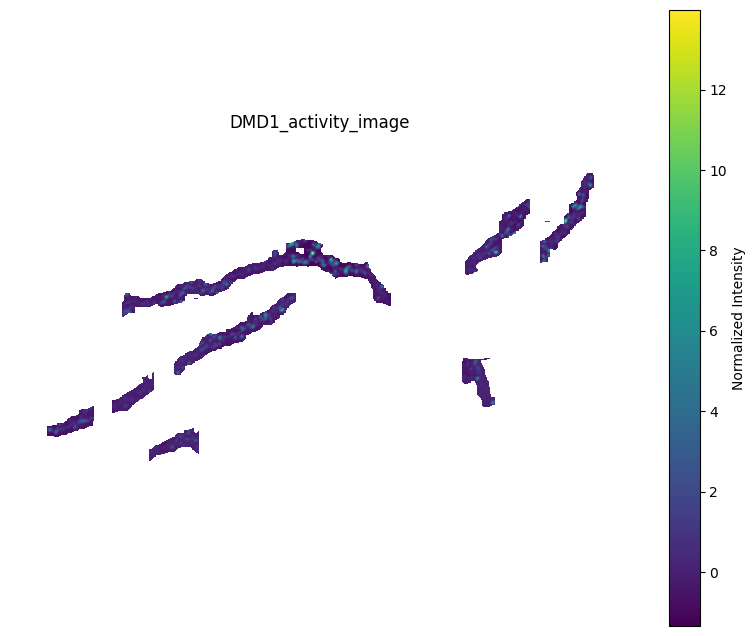

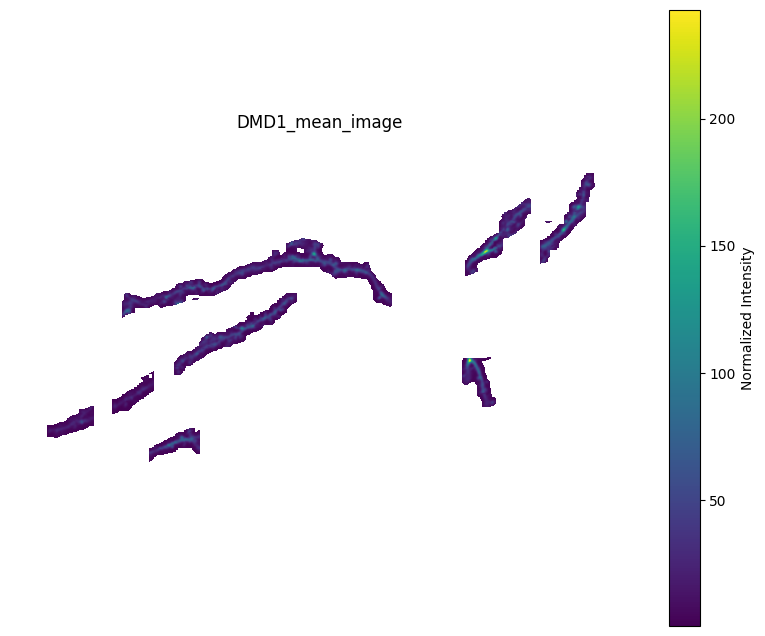

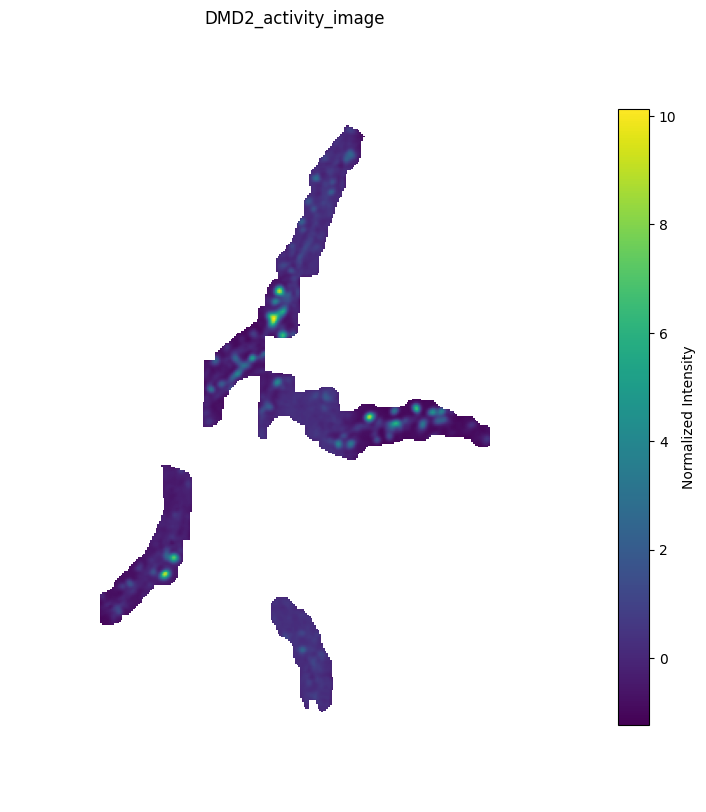

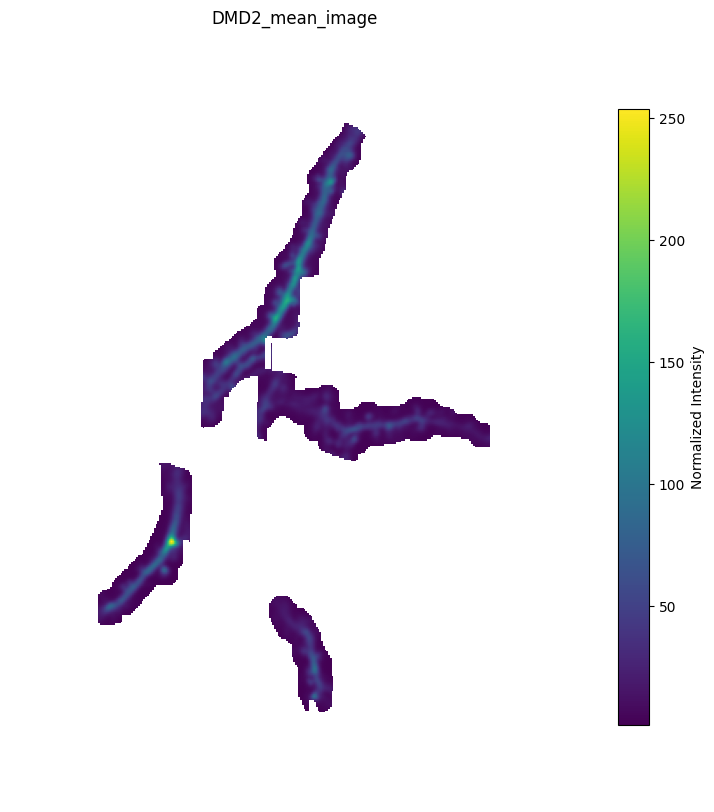

In [102]:
from pynwb import NWBHDF5IO
import matplotlib.pyplot as plt
import numpy as np
from pynwb.image import ImageSeries

nwb_path = r"C:\Users\nicho\Downloads\sub-794237_image+ophys.nwb"

with NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()

    for name, obj in nwbfile.acquisition.items():
        if isinstance(obj, ImageSeries):
            print(f"Displaying: {name}")
            try:
                img_data = obj.data[:]

                # Handle 3D shapes like (1, H, W)
                if img_data.ndim == 3 and img_data.shape[0] == 1:
                    img_data = img_data[0]

                # Plot with colorbar and viridis colormap
                plt.figure(figsize=(10,10))
                im = plt.imshow(img_data, cmap='viridis')
                plt.title(name)
                plt.axis('off')
                plt.colorbar(im, shrink=0.8, label="Normalized Intensity")
                plt.tightlayout()
                plt.show()

            except Exception as e:
                print(f"Could not load image {name}: {e}")

## nwbfile.processing

In [3]:
from pynwb import NWBHDF5IO
import pandas as pd

nwb_path = r"C:\Users\nicho\Documents\data\sub-794237_image+ophys.nwb"
# Load NWB file
with NWBHDF5IO(nwb_path) as io:
    nwbfile = io.read()

    # Get the ophys processing module
    ophys_module = nwbfile.processing['ophys']

    # Get the DfOverF object
    dff_obj = ophys_module.data_interfaces['DfOverF']

    print(type(dff_obj))

    for key in dff_obj.fields:
        print(f"{key}: {type(dff_obj.fields[key])}")

    print(dff_obj.roi_response_series.keys())
    print(f"Number of keys {len(dff_obj.roi_response_series.keys())}")

    # Get shapes of all ROI response series
    shapes = [
        dff_obj.roi_response_series[key].data.shape 
        for key in dff_obj.roi_response_series.keys()
        ]
    meta_df = pd.DataFrame({
        'Key': list(dff_obj.roi_response_series.keys()),
        'Shape': shapes
    })

    # Choose a single trace (e.g., Trial 10, DMD1)
    key = 'Trial10_DMD1_DfOverF'

    # Access the TimeSeries object
    ts = dff_obj.roi_response_series[key]

    # Load the data and timestamps
    x = ts.data[:]               # shape = (num_rois, num_timepoints)
    x = x.T
    t = (ts.timestamps[:] if ts.timestamps is not None else
        ts.starting_time + np.arange(x.shape[1]) * ts.rate)

    print("Shape:", x.shape)       # e.g., (num_rois, num_frames)
    print("Time range (s):", t[0], "to", t[-1])

# Extract trial numbers using regex
meta_df['Trial'] = meta_df['Key'].str.extract(r'Trial(\d+)', expand=False).astype(int)

# Sort by trial number
meta_df_sorted = meta_df.sort_values(by='Trial').reset_index(drop=True)

# Estimate memory usage in bytes (assuming float32 = 4 bytes)
meta_df['Num_Elements'] = meta_df['Shape'].apply(lambda s: s[0] * s[1])
meta_df['Estimated_MB'] = meta_df['Num_Elements'] * 4 / 1e6  # Convert bytes to MB

# Total memory across all trials
total_mb = meta_df['Estimated_MB'].sum()
total_gb = total_mb / 1024

print(f"Estimated total memory usage: {total_mb:.2f} MB ({total_gb:.2f} GB)")

# Sort by largest memory
meta_df_sorted = meta_df.sort_values(by='Estimated_MB', ascending=False)

with pd.option_context('display.max_rows', None):
    display(meta_df_sorted)

<class 'pynwb.ophys.DfOverF'>
roi_response_series: <class 'hdmf.utils.LabelledDict'>
dict_keys(['Trial10_DMD1_DfOverF', 'Trial10_DMD2_DfOverF', 'Trial11_DMD1_DfOverF', 'Trial11_DMD2_DfOverF', 'Trial12_DMD1_DfOverF', 'Trial12_DMD2_DfOverF', 'Trial13_DMD1_DfOverF', 'Trial13_DMD2_DfOverF', 'Trial14_DMD1_DfOverF', 'Trial14_DMD2_DfOverF', 'Trial15_DMD1_DfOverF', 'Trial15_DMD2_DfOverF', 'Trial16_DMD1_DfOverF', 'Trial16_DMD2_DfOverF', 'Trial17_DMD1_DfOverF', 'Trial17_DMD2_DfOverF', 'Trial18_DMD1_DfOverF', 'Trial18_DMD2_DfOverF', 'Trial19_DMD1_DfOverF', 'Trial19_DMD2_DfOverF', 'Trial1_DMD1_DfOverF', 'Trial1_DMD2_DfOverF', 'Trial20_DMD1_DfOverF', 'Trial20_DMD2_DfOverF', 'Trial21_DMD1_DfOverF', 'Trial21_DMD2_DfOverF', 'Trial22_DMD1_DfOverF', 'Trial22_DMD2_DfOverF', 'Trial23_DMD1_DfOverF', 'Trial23_DMD2_DfOverF', 'Trial24_DMD1_DfOverF', 'Trial24_DMD2_DfOverF', 'Trial25_DMD1_DfOverF', 'Trial25_DMD2_DfOverF', 'Trial26_DMD1_DfOverF', 'Trial26_DMD2_DfOverF', 'Trial27_DMD1_DfOverF', 'Trial27_DMD2_DfOv

,Key,Shape,Trial,Num_Elements,Estimated_MB
20,Trial1_DMD1_DfOverF,"(6002, 171)",1,1026342,4.105368
62,Trial39_DMD1_DfOverF,"(5887, 171)",39,1006677,4.026708
74,Trial44_DMD1_DfOverF,"(5887, 171)",44,1006677,4.026708
86,Trial4_DMD1_DfOverF,"(5887, 171)",4,1006677,4.026708
16,Trial18_DMD1_DfOverF,"(5887, 171)",18,1006677,4.026708
122,Trial66_DMD1_DfOverF,"(5887, 171)",66,1006677,4.026708
42,Trial2_DMD1_DfOverF,"(5885, 171)",2,1006335,4.025340
84,Trial49_DMD1_DfOverF,"(5885, 171)",49,1006335,4.025340
80,Trial47_DMD1_DfOverF,"(5885, 171)",47,1006335,4.025340
52,Trial34_DMD1_DfOverF,"(5885, 171)",34,1006335,4.025340


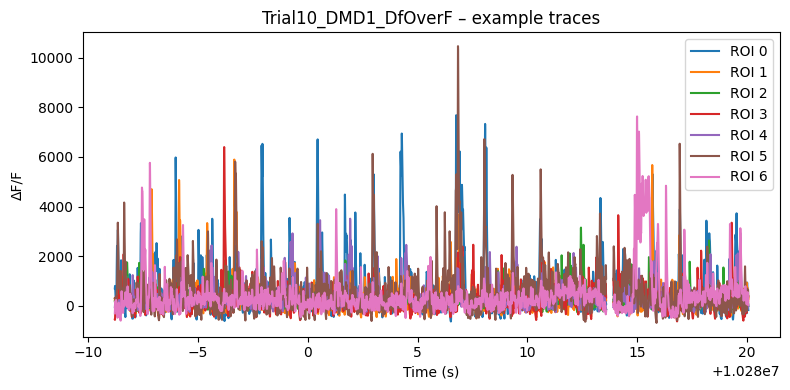

In [4]:
import matplotlib.pyplot as plt
roi_ids = [0, 1, 2, 3, 4, 5, 6]  # or use random.sample(range(x.shape[0]), 3)

plt.figure(figsize=(8, 4))
for roi in roi_ids:
    plt.plot(t, x[roi], label=f'ROI {roi}')
plt.xlabel("Time (s)")
plt.ylabel("ΔF/F")
plt.title(f"{key} – example traces")
plt.legend()
plt.tight_layout()
plt.show()
#

### Fluorescence

In [2]:
from pynwb import NWBHDF5IO
import pandas as pd

nwb_path = r"C:\Users\nicho\Documents\data\sub-794237_image+ophys.nwb"
# Load NWB file
with NWBHDF5IO(nwb_path) as io:
    nwbfile = io.read()

    # Get the ophys processing module
    ophys_module = nwbfile.processing['ophys']

    # Get the DfOverF object
    dff_obj = ophys_module.data_interfaces['Fluorescence']

    print(type(dff_obj))

    for key in dff_obj.fields:
        print(f"{key}: {type(dff_obj.fields[key])}")

    print(dff_obj.roi_response_series.keys())
    print(f"Number of keys {len(dff_obj.roi_response_series.keys())}")

    # Get shapes of all ROI response series
    shapes = [
        dff_obj.roi_response_series[key].data.shape 
        for key in dff_obj.roi_response_series.keys()
        ]
    meta_df = pd.DataFrame({
        'Key': list(dff_obj.roi_response_series.keys()),
        'Shape': shapes
    })

    # Choose a single trace (e.g., Trial 10, DMD1)
    key = 'Trial10_DMD1_Fluorescence'

    # Access the TimeSeries object
    ts = dff_obj.roi_response_series[key]

    # Load the data and timestamps
    x = ts.data[:]               # shape = (num_rois, num_timepoints)
    x = x.T
    t = (ts.timestamps[:] if ts.timestamps is not None else
        ts.starting_time + np.arange(x.shape[1]) * ts.rate)

    print("Shape:", x.shape)       # e.g., (num_rois, num_frames)
    print("Time range (s):", t[0], "to", t[-1])

# Extract trial numbers using regex
meta_df['Trial'] = meta_df['Key'].str.extract(r'Trial(\d+)', expand=False).astype(int)

# Sort by trial number
meta_df_sorted = meta_df.sort_values(by='Trial').reset_index(drop=True)

# Estimate memory usage in bytes (assuming float32 = 4 bytes)
meta_df['Num_Elements'] = meta_df['Shape'].apply(lambda s: s[0] * s[1])
meta_df['Estimated_MB'] = meta_df['Num_Elements'] * 4 / 1e6  # Convert bytes to MB

# Total memory across all trials
total_mb = meta_df['Estimated_MB'].sum()
total_gb = total_mb / 1024

print(f"Estimated total memory usage: {total_mb:.2f} MB ({total_gb:.2f} GB)")

# Sort by largest memory
meta_df_sorted = meta_df.sort_values(by='Estimated_MB', ascending=False)

with pd.option_context('display.max_rows', None):
    display(meta_df_sorted)

C:\Users\nicho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pynwb\file.py:158: UserWarning: Date is missing timezone information. Updating to local timezone.
  args_to_set['date_of_birth'] = _add_missing_timezone(date_of_birth)


<class 'pynwb.ophys.Fluorescence'>
roi_response_series: <class 'hdmf.utils.LabelledDict'>
dict_keys(['Trial10_DMD1_Fluorescence', 'Trial10_DMD2_Fluorescence', 'Trial11_DMD1_Fluorescence', 'Trial11_DMD2_Fluorescence', 'Trial12_DMD1_Fluorescence', 'Trial12_DMD2_Fluorescence', 'Trial13_DMD1_Fluorescence', 'Trial13_DMD2_Fluorescence', 'Trial14_DMD1_Fluorescence', 'Trial14_DMD2_Fluorescence', 'Trial15_DMD1_Fluorescence', 'Trial15_DMD2_Fluorescence', 'Trial16_DMD1_Fluorescence', 'Trial16_DMD2_Fluorescence', 'Trial17_DMD1_Fluorescence', 'Trial17_DMD2_Fluorescence', 'Trial18_DMD1_Fluorescence', 'Trial18_DMD2_Fluorescence', 'Trial19_DMD1_Fluorescence', 'Trial19_DMD2_Fluorescence', 'Trial1_DMD1_Fluorescence', 'Trial1_DMD2_Fluorescence', 'Trial20_DMD1_Fluorescence', 'Trial20_DMD2_Fluorescence', 'Trial21_DMD1_Fluorescence', 'Trial21_DMD2_Fluorescence', 'Trial22_DMD1_Fluorescence', 'Trial22_DMD2_Fluorescence', 'Trial23_DMD1_Fluorescence', 'Trial23_DMD2_Fluorescence', 'Trial24_DMD1_Fluorescence', 'T

,Key,Shape,Trial,Num_Elements,Estimated_MB
20,Trial1_DMD1_Fluorescence,"(6002, 171)",1,1026342,4.105368
62,Trial39_DMD1_Fluorescence,"(5887, 171)",39,1006677,4.026708
74,Trial44_DMD1_Fluorescence,"(5887, 171)",44,1006677,4.026708
86,Trial4_DMD1_Fluorescence,"(5887, 171)",4,1006677,4.026708
16,Trial18_DMD1_Fluorescence,"(5887, 171)",18,1006677,4.026708
122,Trial66_DMD1_Fluorescence,"(5887, 171)",66,1006677,4.026708
42,Trial2_DMD1_Fluorescence,"(5885, 171)",2,1006335,4.025340
84,Trial49_DMD1_Fluorescence,"(5885, 171)",49,1006335,4.025340
80,Trial47_DMD1_Fluorescence,"(5885, 171)",47,1006335,4.025340
52,Trial34_DMD1_Fluorescence,"(5885, 171)",34,1006335,4.025340


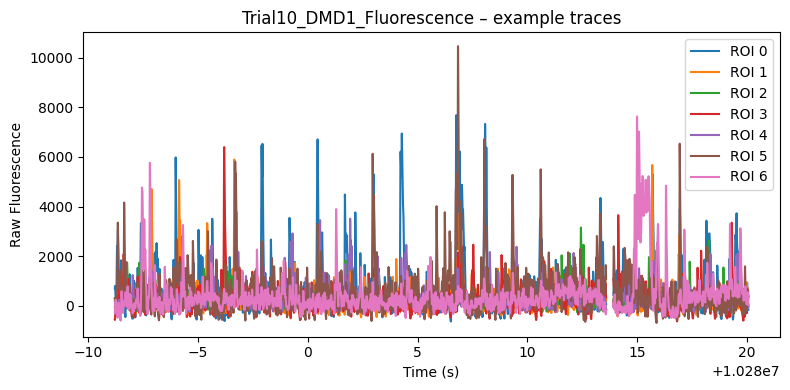

In [27]:
import matplotlib.pyplot as plt
roi_ids = [0, 1, 2, 3, 4, 5, 6]  # or use random.sample(range(x.shape[0]), 3)

plt.figure(figsize=(8, 4))
for roi in roi_ids:
    plt.plot(t, x[roi], label=f'ROI {roi}')
plt.xlabel("Time (s)")
plt.ylabel("Raw Fluorescence")
plt.title(f"{key} – example traces")
plt.legend()
plt.tight_layout()
plt.show()


### Image Segmentation

In [ ]:
# Access the ImageSegmentation module
img_seg = nwbfile.processing['ophys'].data_interfaces['ImageSegmentation']

# List all available plane segmentations
print(img_seg.plane_segmentations.keys())

# Inspect metadata for each plane
for name, plane_seg in img_seg.plane_segmentations.items():
    print(f"PlaneSegmentation name: {name}")
    print(f"Imaging plane source: {plane_seg.imaging_plane.name}")

dict_keys(['DMD1_plane_segmentation', 'DMD2_plane_segmentation'])
PlaneSegmentation name: DMD1_plane_segmentation
Imaging plane source: iGluSnFR4_DMD1
PlaneSegmentation name: DMD2_plane_segmentation
Imaging plane source: iGluSnFR4_DMD2


C:\Users\nicho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pynwb\file.py:158: UserWarning: Date is missing timezone information. Updating to local timezone.
  args_to_set['date_of_birth'] = _add_missing_timezone(date_of_birth)


img_seg keys: dict_keys(['DMD1_plane_segmentation', 'DMD2_plane_segmentation'])
DMD1_plane_segmentation iGluSnFR4_DMD1
Number of ROIs: 171
Available ROI properties: ['image_mask']
plane_mask.shape: (171, 514, 878)


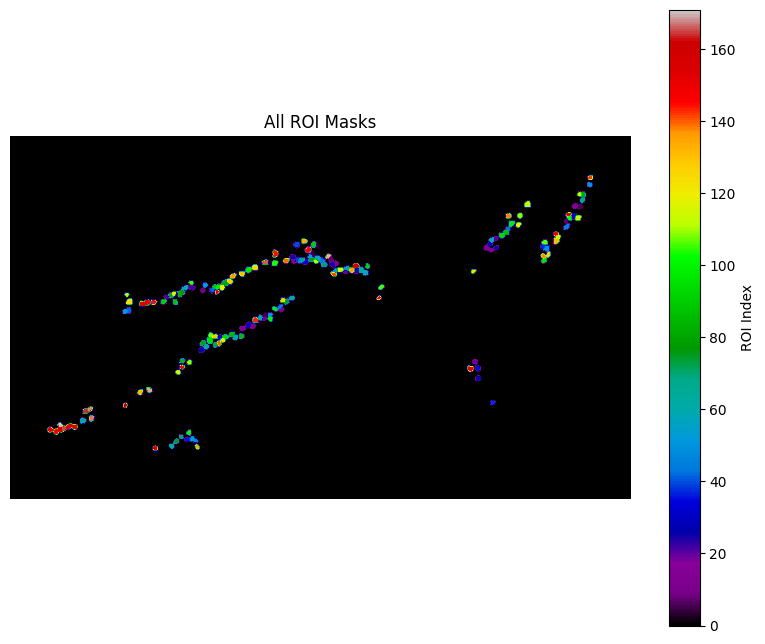

DMD2_plane_segmentation iGluSnFR4_DMD2
Number of ROIs: 52
Available ROI properties: ['image_mask']
plane_mask.shape: (52, 442, 327)


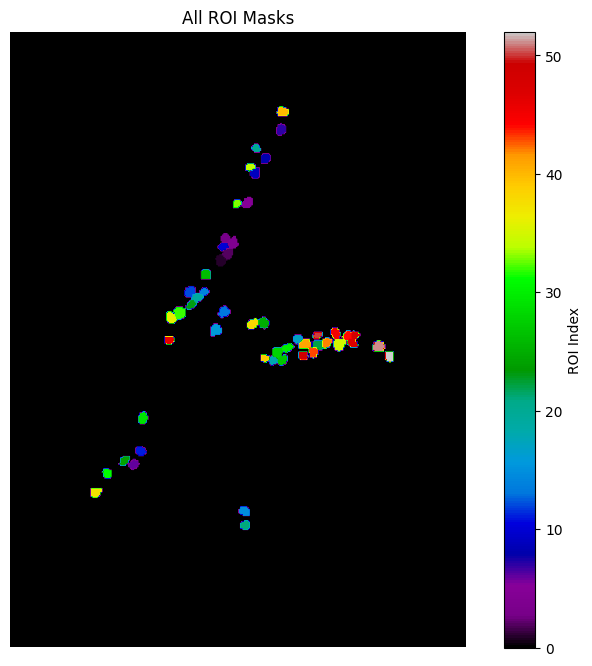

Type of plane_seg: <class 'pynwb.ophys.PlaneSegmentation'>


In [ ]:
from pynwb import NWBHDF5IO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

nwb_path = r"C:\Users\nicho\Documents\data\sub-794237_image+ophys.nwb"
roi_index=0
# Load NWB file
with NWBHDF5IO(nwb_path) as io:
    nwbfile = io.read()

    img_seg = nwbfile.processing['ophys'].data_interfaces['ImageSegmentation']
    print(f"img_seg keys: {img_seg.plane_segmentations.keys()}")

    for name, plane_seg in img_seg.plane_segmentations.items():
        print(name, plane_seg.imaging_plane.name)
        print(f"Number of ROIs: {len(plane_seg)}")
        print("Available ROI properties:", [col.name for col in plane_seg.columns])
        plane_mask = plane_seg['image_mask']
        print(f"plane_mask.shape: {plane_mask.shape}")

        # Initialize blank canvas
        label_image = np.zeros_like(plane_mask[0], dtype=int)

        # Assign each ROI a unique integer label
        for i in range(plane_mask.shape[0]):
            label_image[plane_mask[i] > 0] = i + 1  # Add 1 to avoid background = 0

        plt.figure(figsize=(10,8))
        plt.imshow(label_image, cmap='nipy_spectral')
        plt.title('All ROI Masks')
        plt.axis('off')
        plt.colorbar(label='ROI Index')
        plt.show()

    plane_seg = img_seg.plane_segmentations['DMD1_plane_segmentation']
    print(f"Type of plane_seg: {type(plane_seg)}")


# Load Function Class

In [151]:
from pathlib import Path
from pynwb import NWBHDF5IO
import pandas as pd
import numpy as np
from collections import defaultdict
import warnings

class NwbData:
    def __init__(self, data_path: Path):
        self.data_path = data_path
        self.io=None
        self.nwbfile=None

    def __enter__(self):
        self.io=NWBHDF5IO(str(self.data_path),mode='r')
        self.nwbfile=self.io.read()
        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        if self.io is not None:
            self.io.close()

    def load_meta_data(self) -> pd.DataFrame:
        dff_obj = self.nwbfile.processing['ophys'].data_interfaces['DfOverF']
        keys = list(dff_obj.roi_response_series.keys())
        shapes = [dff_obj.roi_response_series[key].data.shape for key in keys]

        meta_df = pd.DataFrame({'Key': keys, 'Shape': shapes})
        meta_df['Trial'] = meta_df['Key'].str.extract(r'Trial(\d+)', expand=False).astype(int)
        meta_df_sorted = meta_df.sort_values(by='Trial').reset_index(drop=True)
        return meta_df_sorted
    
    def load_sampling_rate_info(self, dFoverF_data) -> pd.DataFrame:
        trial_rates = []

        # Sort trials by number
        sorted_trials = sorted(dFoverF_data.items(), key=lambda x: x[0])
        first_trial_start_time = sorted_trials[0][1]['time'][0]

        for trial_name, trial_data in sorted_trials:
            t = trial_data['time']
            if len(t) < 2:
                print(f"Warning: Note enough data to estimate rate for {trial_name}")
                continue

            dt = np.diff(t)
            mean_rate = 1 / np.mean(dt)
            median_rate = 1 / np.median(dt)
            std_dt = np.std(dt)

            # Total time
            normed_timestamps = t - t[0]
            total_trial_duration = normed_timestamps[-1]
            trial_start_relative_to_first_trial = t[0] - first_trial_start_time
            trial_end_relative_to_first_trial = t[-1] - first_trial_start_time

            trial_rates.append({
                'Trial': trial_name,
                'Duration': round(total_trial_duration, 3),
                'Trial Start (w.r.t. initial trial)': round(trial_start_relative_to_first_trial, 3),
                'Trial End (w.r.t. initial trial)': round(trial_end_relative_to_first_trial, 3),
                'Mean Rate (Hz)': round(mean_rate, 2),
                'Median Rate (Hz)': round(median_rate, 2),
                'Mean Δt (ms)': round(np.mean(dt) * 1000, 3),
                'Median Δt (ms)': round(np.median(dt) * 1000, 3),
                'Δt Std (ms)': round(std_dt * 1000, 4),
                'Num Frames': len(t),
            })

        rate_df = pd.DataFrame(trial_rates).sort_values('Trial').reset_index(drop=True)
        return rate_df
    
    def load_stimulus_data(self) -> pd.DataFrame:
        stim_table = self.nwbfile.intervals['stimulus_presentations']
        stim_df = stim_table.to_dataframe()
        return stim_df
    
    def load_dFoverF_data(self):
        data_dict = defaultdict(dict)
        dff_obj = self.nwbfile.processing['ophys'].data_interfaces['DfOverF']

        trial_start_times = {}
        trial1_time0=None

        # First pass: find Trial1 start time
        for key in dff_obj.roi_response_series.keys():
            if key.startswith('Trial1'):
                ts = dff_obj.roi_response_series[key]
                if ts.timestamps is None:
                    raise ValueError(f"Timestamps missing for {key}")
                trial1_time0 = ts.timestamps[0]
                t0 = ts.timestamps[0]

                trial_id = key.split('_')[0]
                trial_start_times[trial_id] = min(trial_start_times.get(trial_id, t0), t0)

                if trial_id == 'Trial1':
                    trial1_time0 = t0

        if trial1_time0 is None:
            raise ValueError("Could not find Trial1 to anchor timestamps.")
        
        # Check if Trial1 is the earliest
        earliest_time = min(trial_start_times.values())
        if trial1_time0 > earliest_time:
            warnings.warn(
                f"Trial1 does not have the earliest timestamp. "
                f"Trial1 starts at {trial1_time0:.3f}, but earliest trial starts at {earliest_time:.3f}."
            )
        
        # Second pass: load and normalize all trials relative to Trial1 start
        for key in dff_obj.roi_response_series.keys():
            ts = dff_obj.roi_response_series[key]
            x = ts.data[:].T  # (timepoints, rois)

            if ts.timestamps is None:
                raise ValueError(f"Timestamps missing for {key}")
            t = ts.timestamps[:] - trial1_time0

            trial_str = key.split('_')[0] # e.g., 'Trial1'
            trial_id = int(trial_str.replace('Trial','')) # e.g., 1
            dmd_id = 'DMD1' if 'DMD1' in key else 'DMD2'
            data_dict[trial_id][dmd_id] = x
            data_dict[trial_id]['time'] = t
        return data_dict
    
    def add_stimulus_timeseries(self, dFoverF_data, stim_df, features=('orientation', 'contrast', 'x_position', 'y_position', 'delay',
                                                                    'diameter', 'spatial_frequency', 'temporal_frequency')):
        stim_df = stim_df.copy()
        stim_df['trial']=stim_df['trial'].astype(int)

        for trial_id, trial_data in dFoverF_data.items():
            t = trial_data['time']
            stim_ts = {feat: np.full_like(t,np.nan, dtype=float) for feat in features}

            trial_stimuli = stim_df[stim_df['trial'] == trial_id]

            for _,row in trial_stimuli.iterrows():
                # Find time indices within stimulus window
                stim_mask = (t >= row['start_time']) & (t <= row['stop_time'])
                for feat in features:
                    stim_ts[feat][stim_mask] = row[feat]

            dFoverF_data[trial_id]['stim_ts'] = stim_ts # Dict of np.array_split

        return dFoverF_data
    
nwb_path = Path(r"C:\Users\nicho\Documents\data\sub-794237_image+ophys.nwb")

with NwbData(nwb_path) as file:
    stim_df = file.load_stimulus_data()
    dff_data = file.load_dFoverF_data()
    meta_df = file.load_meta_data()
    rate_df = file.load_sampling_rate_info(dFoverF_data=dff_data)
    meta_data = pd.merge(meta_df, rate_df, on='Trial')
    data = file.add_stimulus_timeseries(dff_data, stim_df)

C:\Users\nicho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pynwb\file.py:158: UserWarning: Date is missing timezone information. Updating to local timezone.
  args_to_set['date_of_birth'] = _add_missing_timezone(date_of_birth)


### Loading Function

In [ ]:
import sys
sys.path.append(r"C:/Users/nicho/Documents/Github/openscope-community-predictive-processing/code")
from pathlib import Path
from nwb_io.load import NwbData as nwb
import pandas as pd
nwb_path = Path(r"C:\Users\nicho\Documents\data\sub-794237_image+ophys.nwb")

with nwb(nwb_path) as file:
    stim_df = file.load_stimulus_data()
    dff_data = file.load_dFoverF_data()
    meta_df = file.load_meta_data()
    rate_df = file.load_sampling_rate_info(dFoverF_data=dff_data)
    meta_data = pd.merge(meta_df, rate_df, on='Trial')
    data = file.add_stimulus_timeseries(dff_data, stim_df)

C:\Users\nicho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pynwb\file.py:158: UserWarning: Date is missing timezone information. Updating to local timezone.
  args_to_set['date_of_birth'] = _add_missing_timezone(date_of_birth)


In [27]:
data[68]

{'DMD1': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'time': array([2010.029024  , 2010.03217103, 2010.03531806, ..., 2028.53671394,
        2028.53986097, 2028.543008  ]),
 'DMD2': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'stim_ts': {'orientation': array([nan, nan, nan, ...,  0.,  0.,  0.]),
  'contrast': array([       nan,        nan,        nan, ..., 0.80000001, 0.80000001,
         0.80000001]),
  'x_position': array([ nan,  nan,  nan, ..., -10., -10., -10.]),
  'y_position': array([nan, nan, nan, ..., 10.

## nwbfile.intervals

In [19]:
from pynwb import NWBHDF5IO
from pathlib import Path

nwb_path = Path(r"C:\Users\nicho\Documents\data\sub-794237_image+ophys.nwb")

with NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()

    stim_table = nwbfile.intervals['stimulus_presentations']

    # List all columns
    print("Columns:", stim_table.colnames)

    # Safely access the first 5 entries of each column
    for col in stim_table.colnames:
        try:
            print(f"\n{col}:")
            print(stim_table[col][:])  # ← only works while file is open
        except Exception as e:
            print(f"Error reading column '{col}': {e}")

    stim_df = stim_table.to_dataframe()        

Columns: ('start_time', 'stop_time', 'orientation', 'trial', 'delay', 'diameter', 'x_position', 'y_position', 'contrast', 'spatial_frequency', 'temporal_frequency')

start_time:
[   8.317024    9.583008   10.850016 ... 2057.196    2057.729024
 2058.263008]

stop_time:
[   8.567024    9.833008   11.100016 ... 2057.446    2057.979024
 2058.513008]

orientation:
[3.92699075 2.7488935  5.10508823 ... 0.78539819 0.         1.57079637]

trial:
[ 1.  1.  1. ... 69. 69. 69.]

delay:
[1.   1.   1.   ... 0.25 0.25 0.25]

diameter:
[360. 360. 360. ...  20.  20.  20.]

x_position:
[  0.   0.   0. ... -10.  30. -30.]

y_position:
[  0.   0.   0. ... -20.  20.  30.]

contrast:
[1.         1.         1.         ... 0.80000001 0.80000001 0.80000001]

spatial_frequency:
[0.04 0.04 0.04 ... 0.08 0.08 0.08]

temporal_frequency:
[2. 2. 2. ... 4. 4. 4.]


C:\Users\nicho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pynwb\file.py:158: UserWarning: Date is missing timezone information. Updating to local timezone.
  args_to_set['date_of_birth'] = _add_missing_timezone(date_of_birth)


In [ ]:
import numpy as np
from collections import Counter
from pynwb import NWBHDF5IO

nwb_path = r"C:\Users\nicho\Downloads\sub-794237_image+ophys.nwb"

with NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()

    stim_table = nwbfile.intervals['stimulus_presentations']

    # Extract the trial labels (make sure to cast to int if needed)
    trial_ids = stim_table['trial'][:].astype(int)

    # Count how many times each trial appears
    trial_counts = Counter(trial_ids)

    # Convert to a sorted list of (trial_id, count)
    sorted_counts = sorted(trial_counts.items())

    # Display
    for trial_id, count in sorted_counts:
        print(f"Trial {trial_id}: {count} stimuli")


Trial -1: 44 stimuli
Trial 1: 17 stimuli
Trial 2: 23 stimuli
Trial 3: 24 stimuli
Trial 4: 23 stimuli
Trial 5: 23 stimuli
Trial 6: 24 stimuli
Trial 7: 23 stimuli
Trial 8: 23 stimuli
Trial 9: 24 stimuli
Trial 10: 23 stimuli
Trial 11: 23 stimuli
Trial 12: 24 stimuli
Trial 13: 23 stimuli
Trial 14: 23 stimuli
Trial 15: 23 stimuli
Trial 16: 23 stimuli
Trial 17: 23 stimuli
Trial 18: 23 stimuli
Trial 19: 23 stimuli
Trial 20: 23 stimuli
Trial 21: 23 stimuli
Trial 22: 24 stimuli
Trial 23: 23 stimuli
Trial 24: 23 stimuli
Trial 25: 24 stimuli
Trial 26: 23 stimuli
Trial 27: 23 stimuli
Trial 28: 24 stimuli
Trial 29: 23 stimuli
Trial 30: 23 stimuli
Trial 31: 24 stimuli
Trial 32: 23 stimuli
Trial 33: 23 stimuli
Trial 34: 23 stimuli
Trial 35: 23 stimuli
Trial 36: 23 stimuli
Trial 37: 23 stimuli
Trial 38: 23 stimuli
Trial 39: 23 stimuli
Trial 40: 23 stimuli
Trial 41: 24 stimuli
Trial 42: 23 stimuli
Trial 43: 23 stimuli
Trial 44: 24 stimuli
Trial 45: 23 stimuli
Trial 46: 23 stimuli
Trial 47: 24 stimuli
T